# PRÁCTICA MACHINE LEARNING KEEPCODING 2020

### Importamos todas lasl librerías que vayamos a utilizar en el proyecto

In [1]:
import pandas as pd #To work with dataframes
import numpy as np #To operate with the data.
import sklearn #To use lineal regresion models.
import operator #To sort a dictionary.
from sklearn.feature_selection import f_regression, mutual_info_regression

In [2]:
import matplotlib.pyplot as plt # para dibujar

%matplotlib inline
from matplotlib import cm

plt.rcParams['figure.figsize'] = (16, 16)
plt.style.use('ggplot')

### Leemos el dataset que tenemos en formato .csv y lo convertimos en un dataframe

In [3]:
#Pandas nos mostrará todas los columnas y filas sin sesgar la información.
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [4]:
#Leemos el csv de airbnb y lo convertimos en un dataframe.
df = pd.read_csv("airbnb-listings-extract.csv", sep=";")

Voy a filtrar el campo de "City" por Madrid, ya que no tiene sentido comparar viviendas que sean de distintas ciudades o incluso de distintos países. Ya que el precio de la vivienda varia mucho dependiendo de la ciudad. 

#### Se podría filtrar por país directamente o por cualquier otra ciudad.

In [5]:
# Me quedo unicamente con las viviendas de Madrid.
df = df[df["City"] == "Madrid"]

In [6]:
#Cambio el nombre de las columnas sustituyendo los espacios en blanco por barras bajas para poder trabajar mejor
# a posteriori con el dataframe
new_columns = [str(column).replace(" ","_") for column in df.columns]
df.columns = new_columns

### Selección de las columnas más relevantes.

In [7]:
# Me quedo con las columnas más útiles.
# Por útiles entiendo parámetros que tienen en común todas las viviendas, es decir, número de habitaciones, número de reviews
# código postal. Es decir, datos concretos.

# Elimino todos aquellos datos que son abstractos como fechas, url's, Ids de varios tipos, opiniones, descripciones...

# Aquí basta con añadir una columna a la lista "useful_columns" para incluirla en el dataframe. Se puede cambiar en cualquier 
# momento y añadir o quitar las columnas que se quiera y ejectutar el código de nuevo.

useful_columns =  ["Neighbourhood","Zipcode","Property_Type",
                    "Room_Type", "Accommodates", "Bathrooms", "Bedrooms",
                    "Beds", "Bed_Type", "Price","Number_of_Reviews",
                    "Review_Scores_Value","Cancellation_Policy",
                    "Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit",
                    "Cleaning_Fee"]

df = df[useful_columns]

In [8]:
#Analizo los valores de Zipcode, ya que he visto que hay varios que vienen por defecto con errores.

# Por ello, mediante un replace, solvento todos los errores que he visto al hacer un df_train["Zipcode"].unique()
df["Zipcode"].replace({"28002\n28002": "28002",
                             "Madrid 28004": "28004",
                             "2805":"28005",
                             "2015":"28015",
                             "2815":"28015"}, inplace=True)   

In [9]:
#Convierto el campo "Zipcode" en un campo de tipo numérico para incluirlo en la matriz de correlación.
df["Zipcode"] = df["Zipcode"].apply(pd.to_numeric, errors='coerce')

### Creación de la función "column_encode" para codificar todas aquellas columnas que sean necesarias codificar.

In [10]:
# Función que codifica la columna que le indiquemos dentro de un dataframe:
# Tiene como parámetros el dataframe con el que estamos trabajando y el nombre de la columna que queremos codificar.
# Devuelve el dataframe con la columna original y justo a su derecha, la columna codificada nueva.
# Este modelo tiene de ventajas que podemos incluir o excluir una columna en cualquier momento sin problemas.

def column_encode(dataframe, df_column):

    column_values = dataframe[df_column].unique() 

    dictionary = {}
    counter = 0
    
    columns = list(dataframe.columns)
    
    new_column = f"{df_column}_Code"

    for value in column_values:
        if value not in dictionary.keys():
            if str(value) == "NaN" or str(value) == "Nan" or str(value) == "nan":
                dictionary[value] = value
            else:
                dictionary[value] = counter
                counter =+ counter +1

    df_add = pd.DataFrame({df_column: list(dictionary.keys()),
                                     new_column: list(dictionary.values()) 
                                    })

    dataframe = pd.merge(dataframe, df_add, on= df_column)
    
    for ix, column in enumerate(columns):
        if str(column) == str(df_column):
            columns.insert(ix + 1, new_column)        
    
    dataframe = dataframe[columns]
    
    return dataframe  

### Función "main_encode". Implementa la función de "column_encode".

In [11]:
# La función main_encode recibe como parámetro el dataframe con el que estamos trabajando y codifica todos aquellos
# campos que sea necesario para crear el modelo lineal.

# En esta función es donde tenemos que añadir todos aquellas columnas que queramos codificar.

# Se pueden añadir o quitar campos en cualquier momento que se quiera hacer cambios, pero hay que tener en cuenta que las 
# columnas que incluyamos tienen que estar en el dataframe.

def main_encode(dataframe):
    
    df_encode = column_encode(dataframe,"Neighbourhood")
    df_encode = column_encode(df_encode,"Property_Type")
    df_encode = column_encode(df_encode,"Room_Type")
    df_encode = column_encode(df_encode,"Bed_Type")
    df_encode = column_encode(df_encode,"Cancellation_Policy")
        
    return df_encode

In [12]:
# Ahora llamamos a la función "main_encode" y codificamos todas aquellas columnas que hayamos seleccionado:
df = main_encode(df)

### Función "delete_object_column". Limpieza del dataframe

In [13]:
df_type = df.dtypes.apply(lambda x: x.name).to_dict()
df_type

{'Neighbourhood': 'object',
 'Neighbourhood_Code': 'float64',
 'Zipcode': 'float64',
 'Property_Type': 'object',
 'Property_Type_Code': 'int64',
 'Room_Type': 'object',
 'Room_Type_Code': 'int64',
 'Accommodates': 'int64',
 'Bathrooms': 'float64',
 'Bedrooms': 'float64',
 'Beds': 'float64',
 'Bed_Type': 'object',
 'Bed_Type_Code': 'int64',
 'Price': 'float64',
 'Number_of_Reviews': 'int64',
 'Review_Scores_Value': 'float64',
 'Cancellation_Policy': 'object',
 'Cancellation_Policy_Code': 'int64',
 'Square_Feet': 'float64',
 'Weekly_Price': 'float64',
 'Monthly_Price': 'float64',
 'Security_Deposit': 'float64',
 'Cleaning_Fee': 'float64'}

In [14]:
# Función delete object_columns. Recibe como parámetro el dataframe con el que estamos trabajando.
# Me quedo únicamente con los campos numéricos y los campos codificados.

def delete_object_columns(dataframe):
    
    df_object_columns = dataframe.dtypes.apply(lambda x: x.name).to_dict()
    
    for column in list(df_object_columns.keys()):
        if str(df_object_columns[column]) == 'object':
            dataframe = dataframe.drop(columns = [column])
    
    return dataframe

In [15]:
# La función convert to numeric convierte todos los campos del dataframe a int64.
# Esto lo hago porque pueden saltar errores al ser datos numéricos muy largos de tipo "float".

def convert_to_numeric(dataframe):
    
    dataframe = dataframe.apply(pd.to_numeric, errors='coerce')
    
    return dataframe

### Información del dataset

In [16]:
# Obetenemos información del dataframe.
# En la columna count, ya se aprecia que hay columnas que tienen valores nulos, los cuales tenemos que eliminar para dejar 
# el dataset lo más limpio posible.
df_info = df.describe().T
df_info

,count,mean,std,min,25%,50%,75%,max
Neighbourhood_Code,8753.0,37.383640,17.062318,0.0,25.0,39.0,53.0,64.0
Zipcode,12766.0,28029.070265,2257.586805,28.0,28005.0,28012.0,28016.0,280013.0
Property_Type_Code,13207.0,0.530098,1.655005,0.0,0.0,0.0,0.0,21.0
Room_Type_Code,13207.0,0.627319,0.512576,0.0,0.0,1.0,1.0,2.0
Accommodates,13207.0,3.191035,1.991330,1.0,2.0,2.0,4.0,16.0
Bathrooms,13158.0,1.252736,0.599699,0.0,1.0,1.0,1.0,8.0
Bedrooms,13184.0,1.294372,0.826831,0.0,1.0,1.0,2.0,10.0
Beds,13158.0,1.986016,1.511463,1.0,1.0,2.0,2.0,16.0
Bed_Type_Code,13207.0,0.043613,0.298525,0.0,0.0,0.0,0.0,4.0
Price,13198.0,65.924686,56.008552,9.0,31.0,52.0,80.0,875.0


<!-- ### Análisis de los datos sobre el dataframe original. -->

### Análisis del dataframe original.

#### Cálculo de la cantidad de valores nulos que contienen cada columna.

In [17]:
#Saco el número de filas utilizando la función shape.
max_value = df.shape[0]

In [18]:
#Añado dos campos nuevos al df_info. 
# En campo null_values, indico cuantos valores nulos tiene cada campo.
# En campo null_values_percent, indico porcentaje representan los valores nulos en ese campo.
df_info["null_values"] = max_value - df_info["count"]
df_info["null_values_percent"] = round((df_info["null_values"]/max_value)*100,2)

In [19]:
#Ordeno el df_info por la columna de "null_values"
df_info.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,519.0,378.007707,546.793839,0.0,0.0,108.0,646.0,5167.0,12688.0,96.07
Monthly_Price,3314.0,1347.122812,986.070781,250.0,700.0,1200.0,1680.0,25000.0,9893.0,74.91
Weekly_Price,3349.0,368.633025,191.623325,70.0,200.0,350.0,490.0,999.0,9858.0,74.64
Security_Deposit,5635.0,183.462289,109.056807,70.0,100.0,150.0,200.0,990.0,7572.0,57.33
Cleaning_Fee,7820.0,29.629284,25.938993,4.0,15.0,25.0,35.0,500.0,5387.0,40.79
Neighbourhood_Code,8753.0,37.383640,17.062318,0.0,25.0,39.0,53.0,64.0,4454.0,33.72
Review_Scores_Value,10339.0,9.211916,0.955313,2.0,9.0,9.0,10.0,10.0,2868.0,21.72
Zipcode,12766.0,28029.070265,2257.586805,28.0,28005.0,28012.0,28016.0,280013.0,441.0,3.34
Beds,13158.0,1.986016,1.511463,1.0,1.0,2.0,2.0,16.0,49.0,0.37
Bathrooms,13158.0,1.252736,0.599699,0.0,1.0,1.0,1.0,8.0,49.0,0.37


### Elimino las columnas que poseen más de un 25% de valores nulos.

In [20]:
# Aquí compruebo cuales son las columnas que tienen más de un 25% de valores nulos.
# Al tener tantos valores nulos, voy a eliminarlas directamente.

df_filter = df_info[df_info["null_values_percent"] >= 25]
df_filter.sort_values(by=['null_values'], ascending=False)

,count,mean,std,min,25%,50%,75%,max,null_values,null_values_percent
Square_Feet,519.0,378.007707,546.793839,0.0,0.0,108.0,646.0,5167.0,12688.0,96.07
Monthly_Price,3314.0,1347.122812,986.070781,250.0,700.0,1200.0,1680.0,25000.0,9893.0,74.91
Weekly_Price,3349.0,368.633025,191.623325,70.0,200.0,350.0,490.0,999.0,9858.0,74.64
Security_Deposit,5635.0,183.462289,109.056807,70.0,100.0,150.0,200.0,990.0,7572.0,57.33
Cleaning_Fee,7820.0,29.629284,25.938993,4.0,15.0,25.0,35.0,500.0,5387.0,40.79
Neighbourhood_Code,8753.0,37.383640,17.062318,0.0,25.0,39.0,53.0,64.0,4454.0,33.72


In [21]:
# Elimino las columnas que tienen más de un 25% o más de valores nulos.

columns = ["Square_Feet","Weekly_Price","Monthly_Price","Security_Deposit","Cleaning_Fee","Neighbourhood_Code"]
df = df.drop(columns = columns)

### Limpieza de outlayers

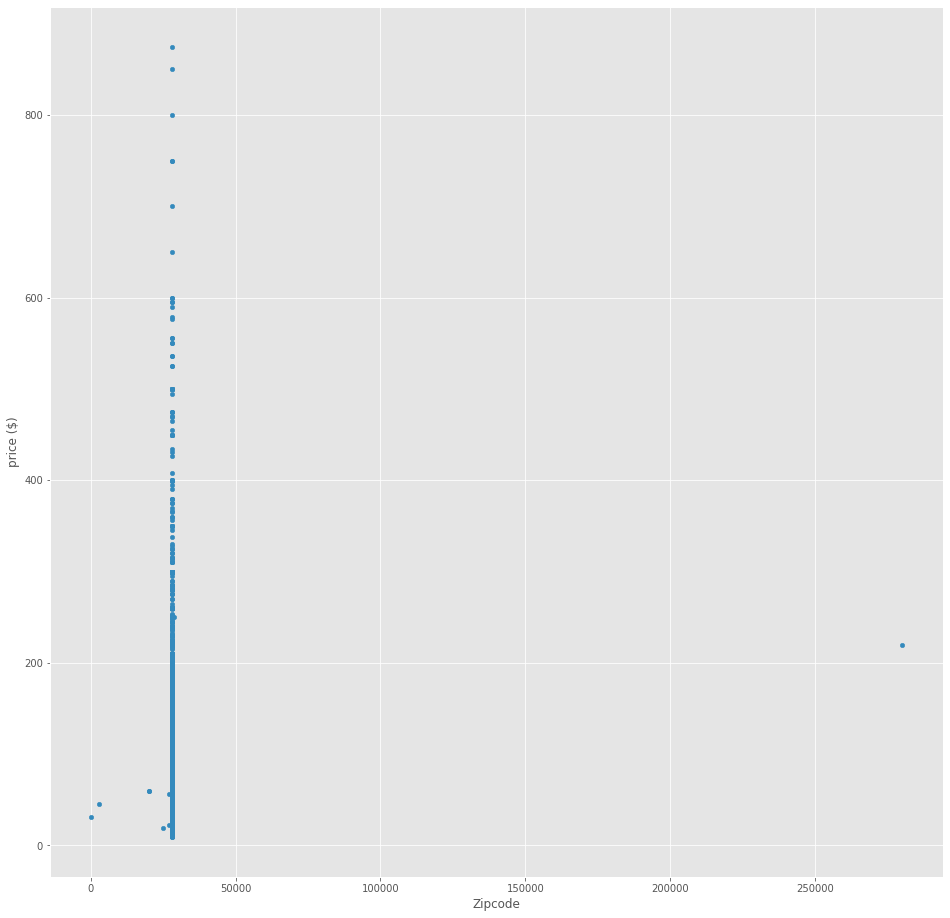

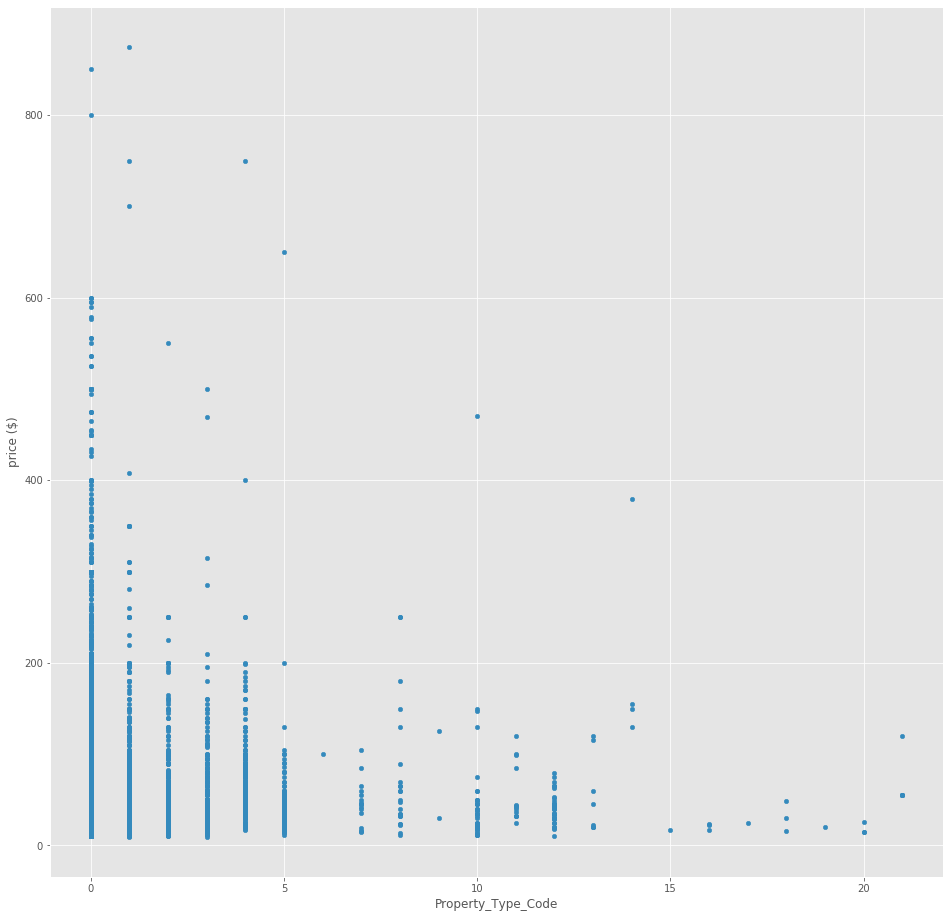

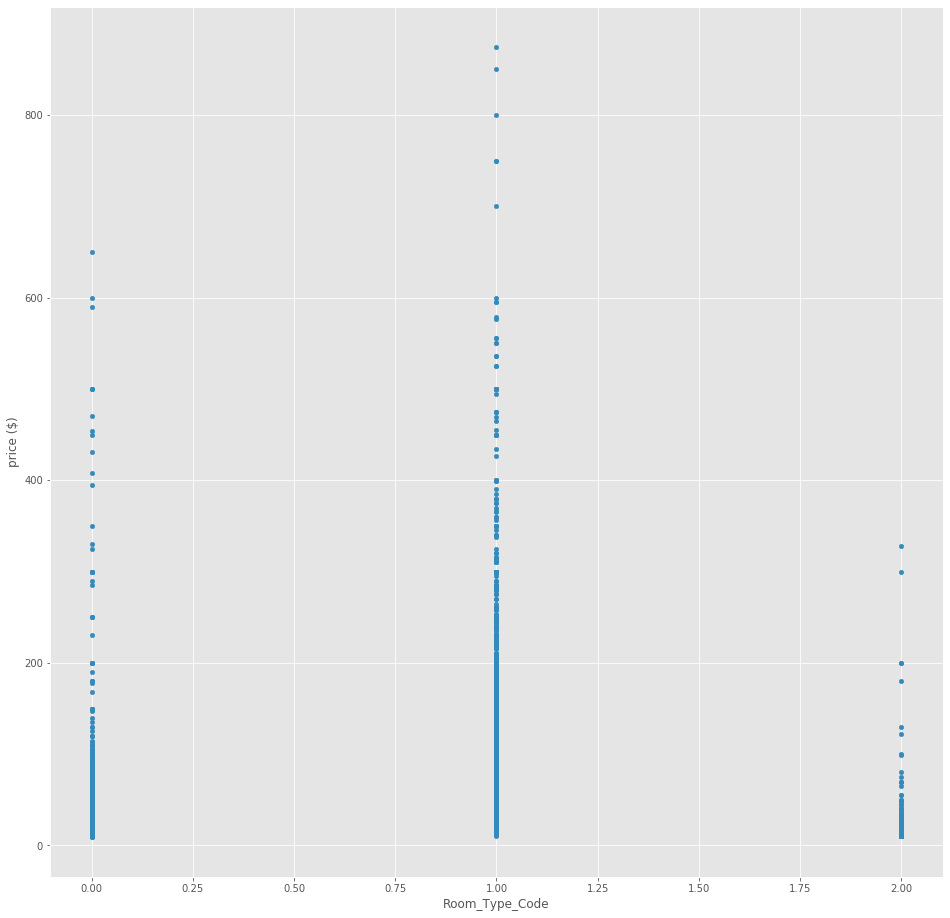

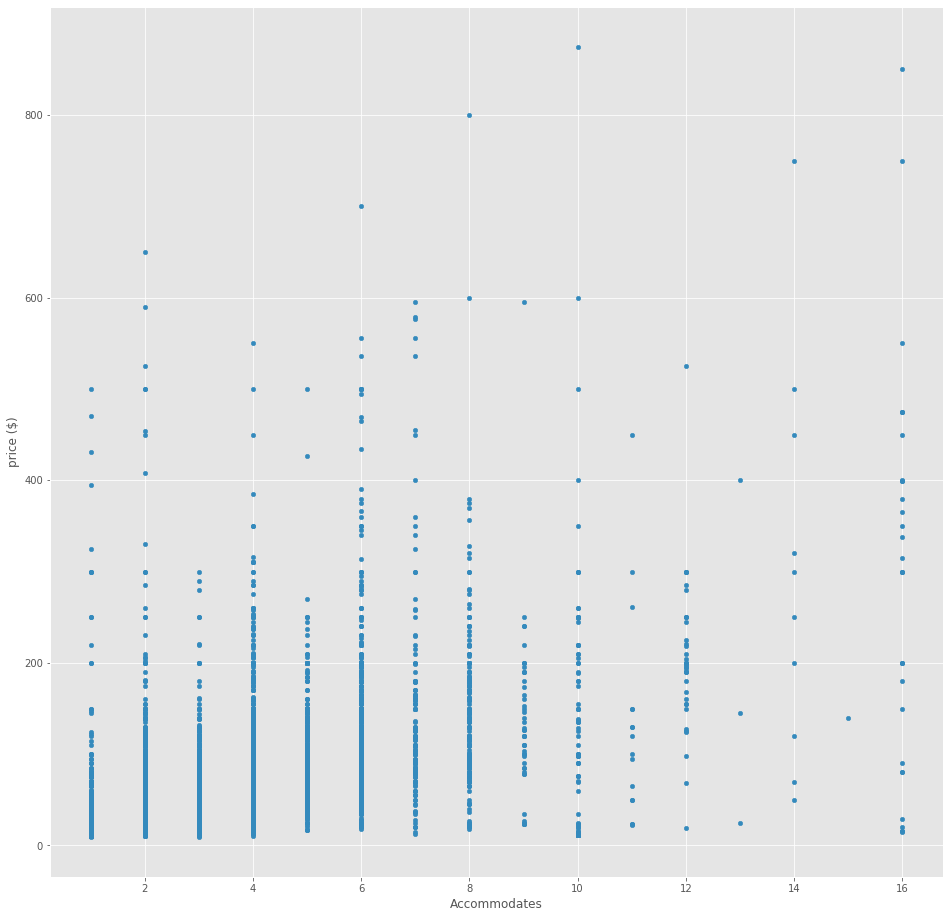

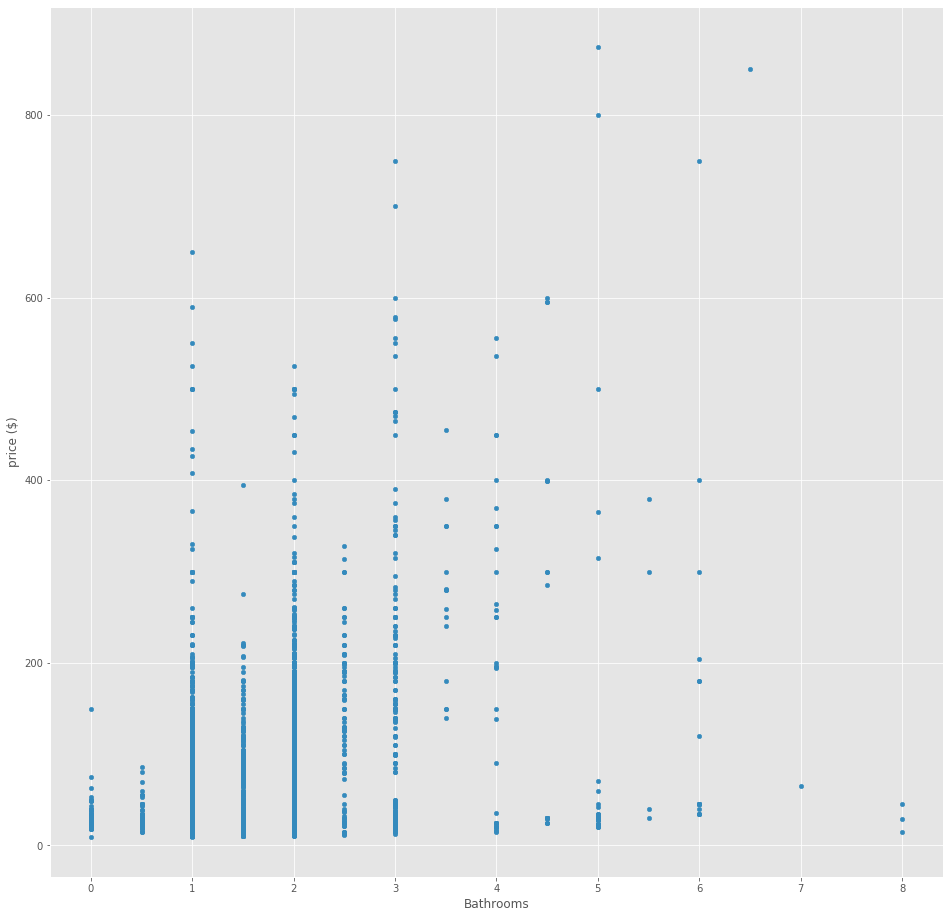

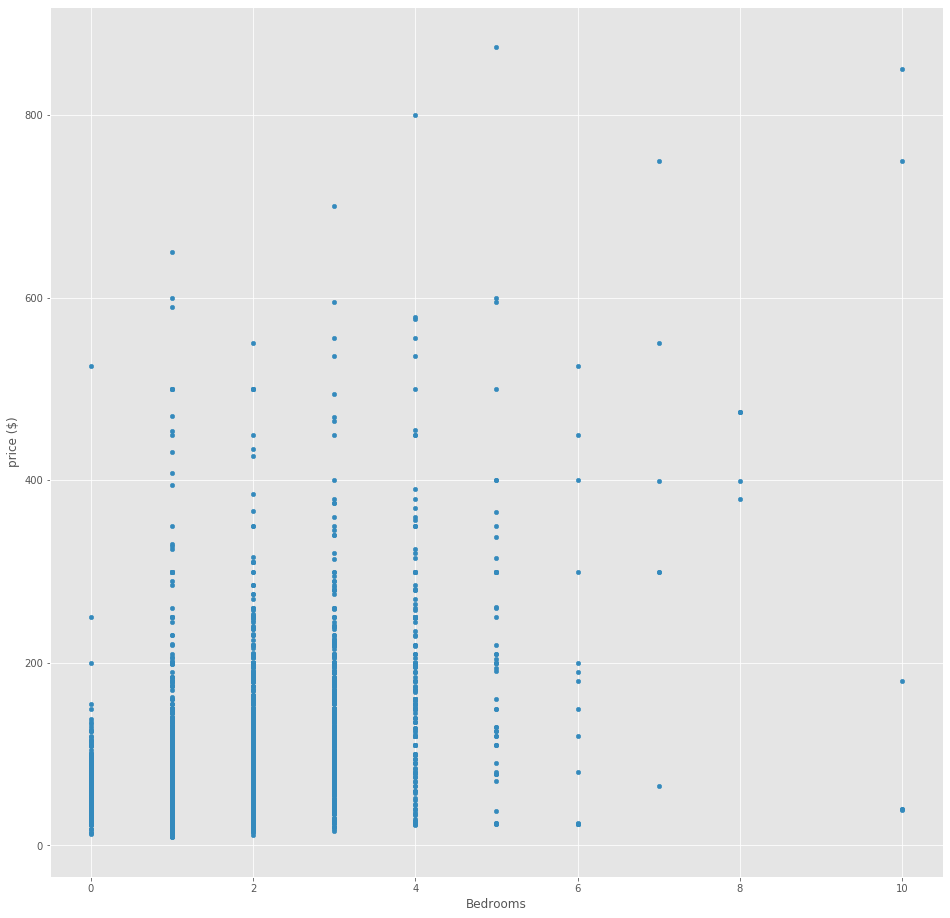

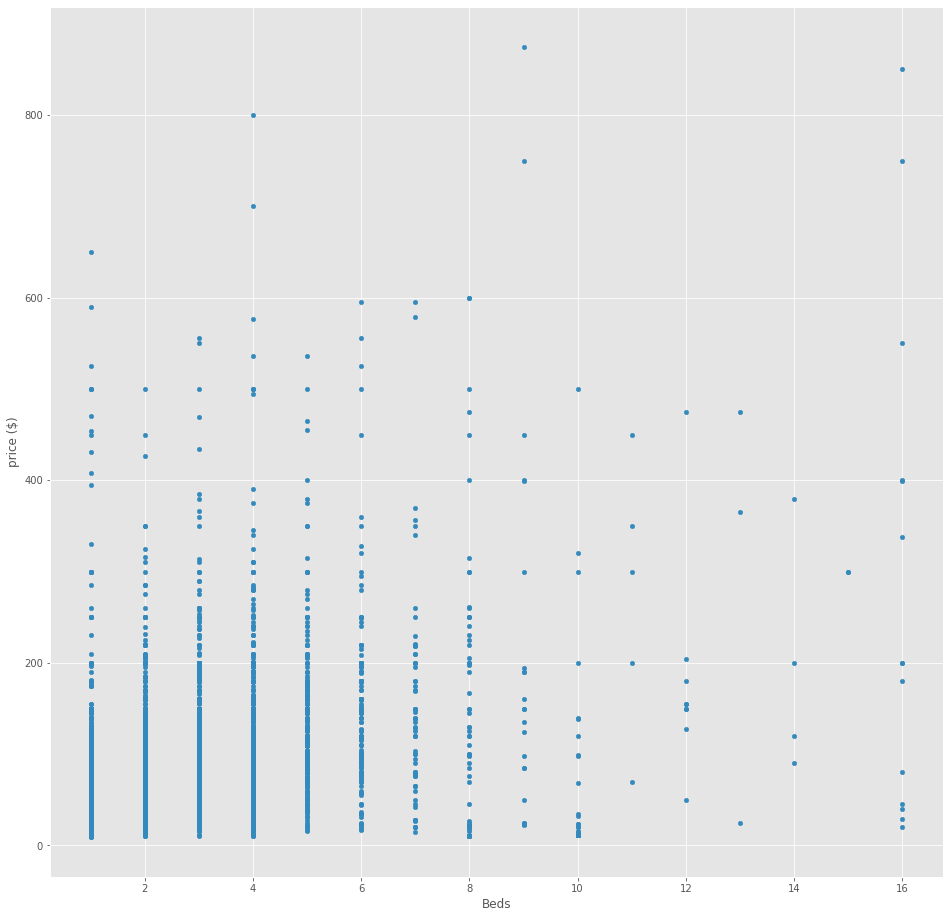

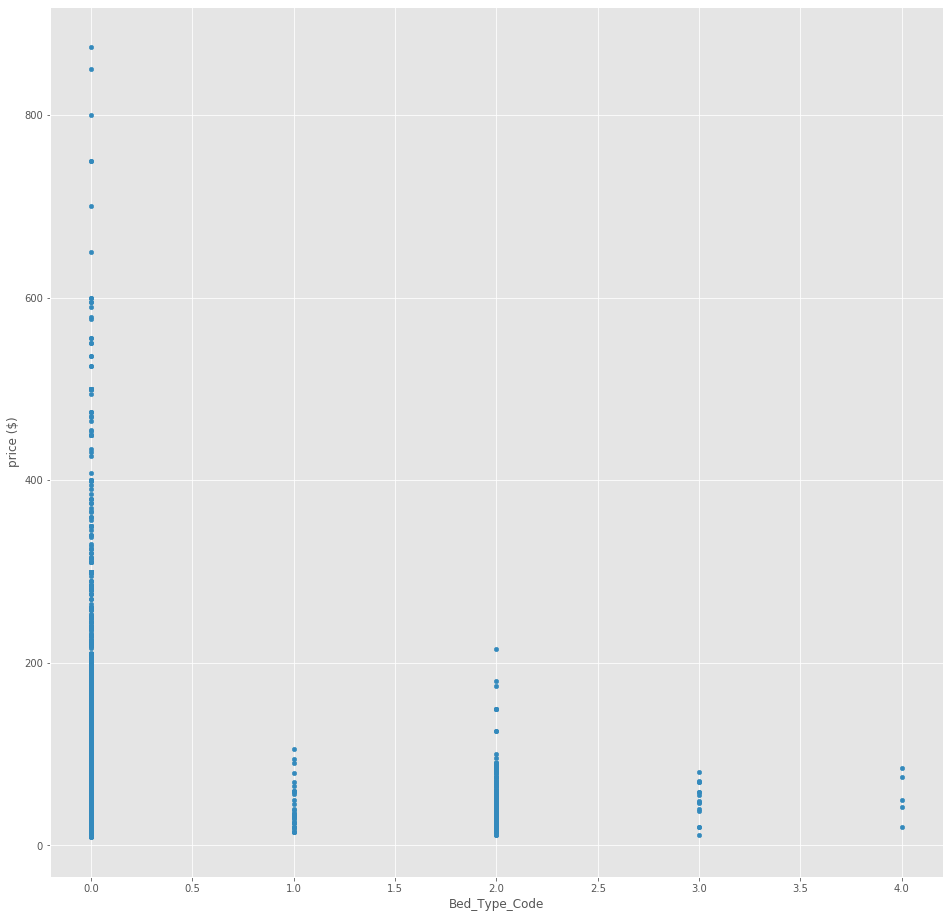

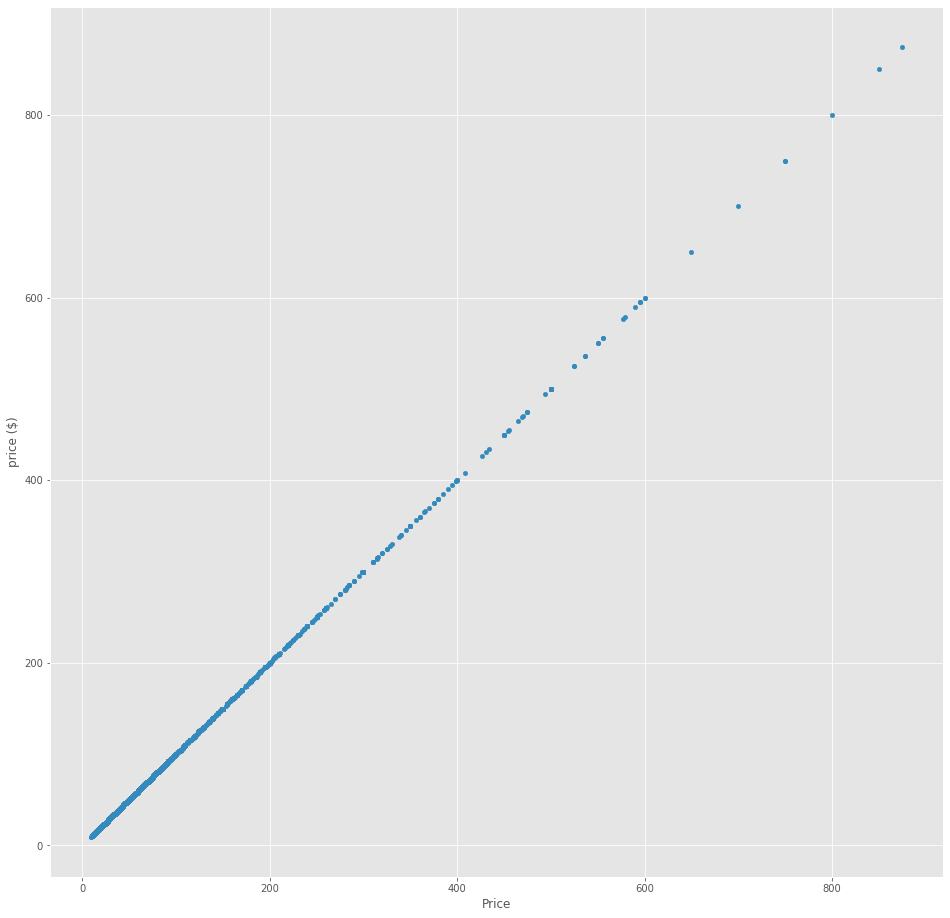

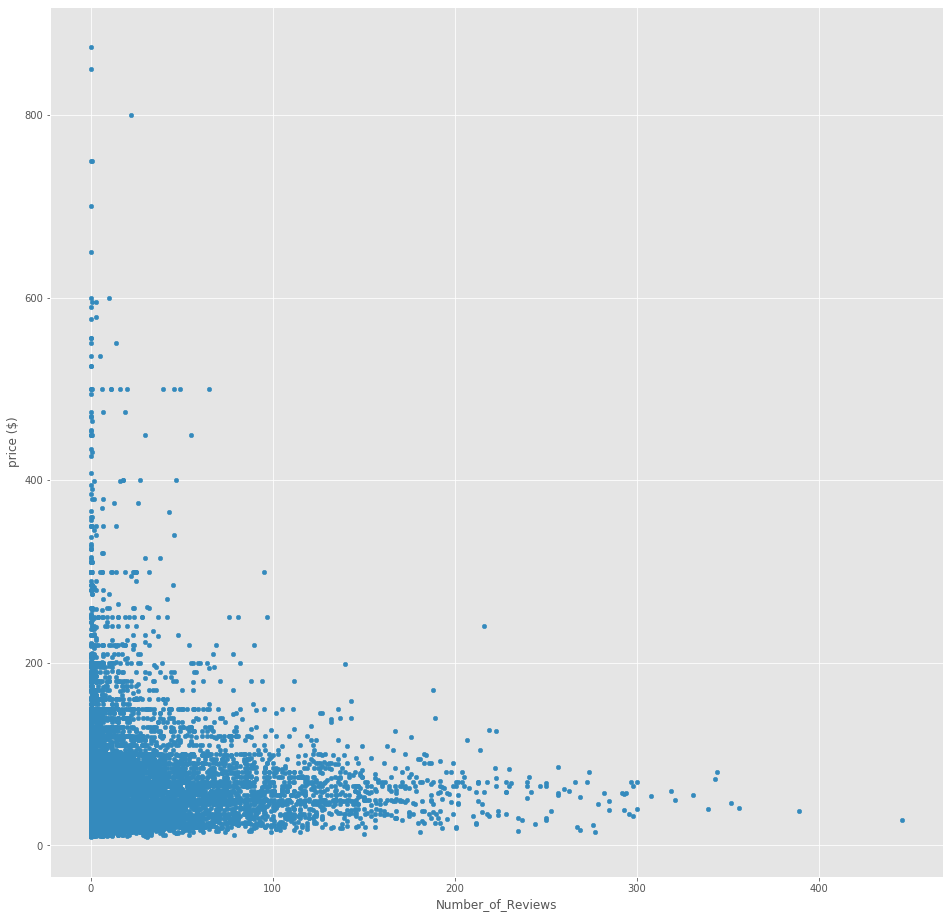

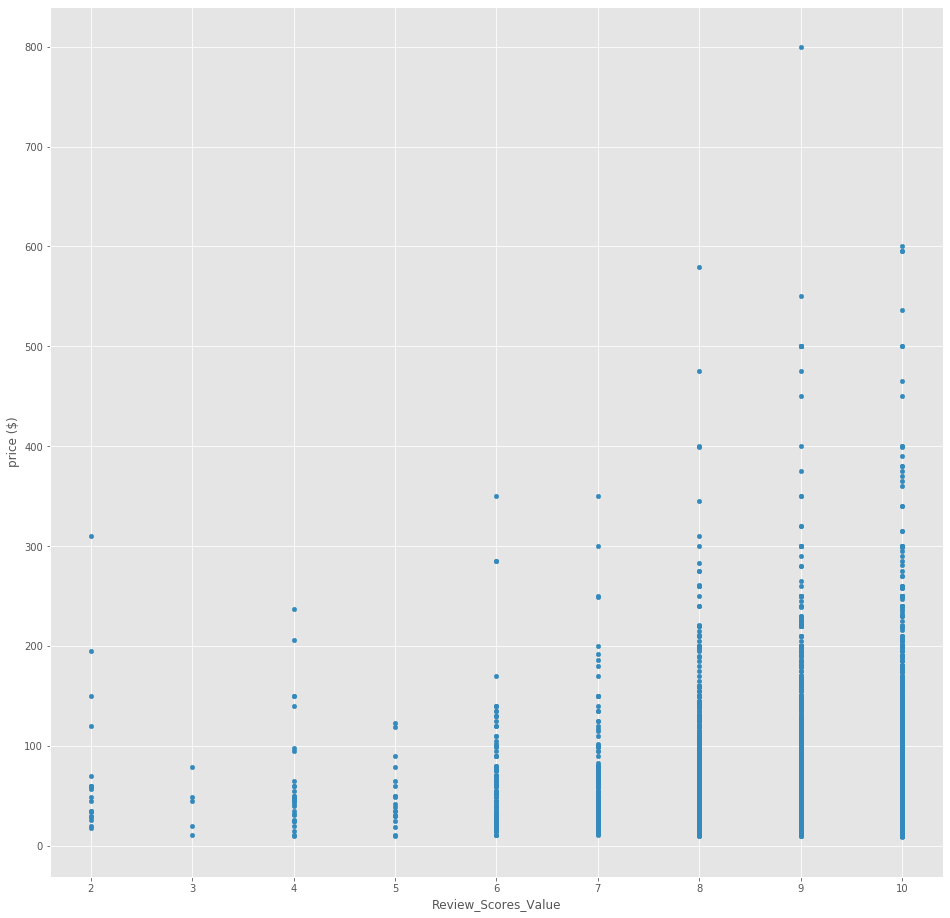

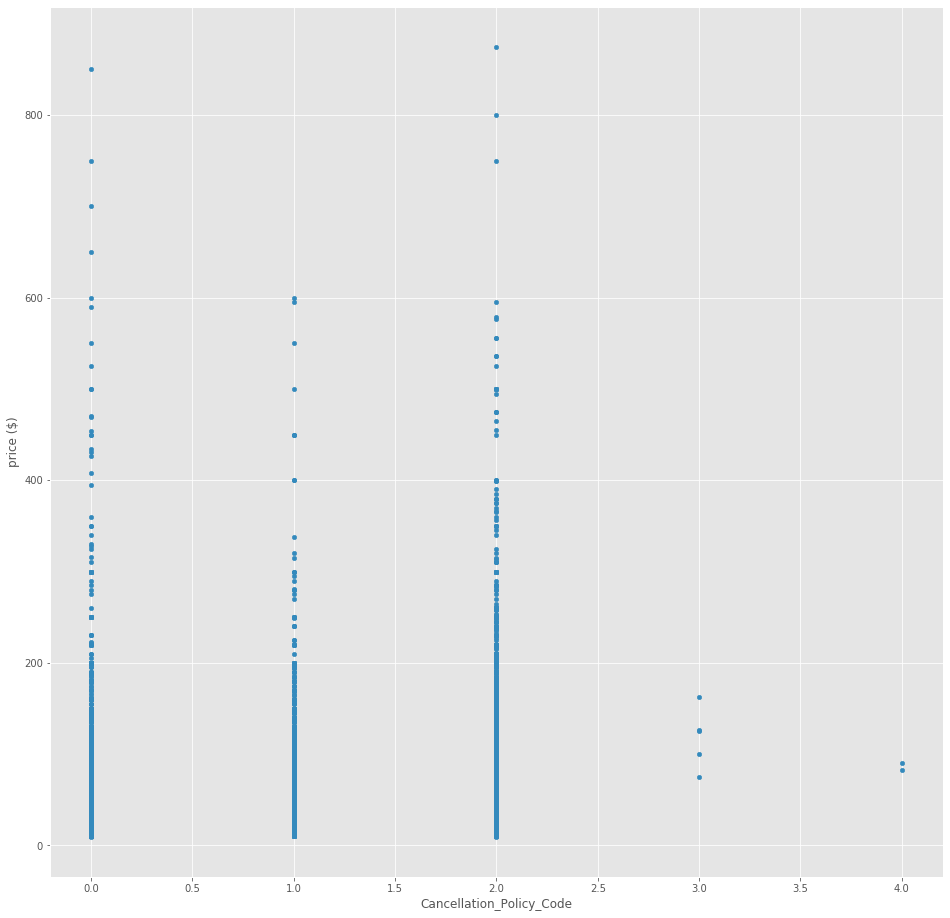

In [22]:
# Aquí voy a plottear todos los campos que tiene el dataframe en función del precio para detectar outlayers y eliminarlos antes
# de dividir el dataset entre train y test

df_filter = df

df_filter = delete_object_columns(df_filter)

for column in df_filter.columns:
    df_filter.plot(kind = 'scatter',x=f'{column}',y = 'Price')
    plt.xlabel(column)
    plt.ylabel('price ($)')
    plt.show()

Por lo que se ve en los plots, hay que filtrar el dataframe para poder filtrar algunos campos que tienen valores que pueden descompensar el dataframe.

En este caso, voy a filtrar los campos bathrooms, bedrooms y price.

In [23]:
df = df[df["Price"] <= 325]
df = df[df["Bathrooms"] <= 6]
df = df[df["Bedrooms"] <= 8]
df = df[df["Zipcode"] >= 28001] # Este valor lo he sacado mirando los códigos postales de madrid
df = df[df["Zipcode"] < 28523] # Este valor lo he sacado mirando los códigos postales de madrid

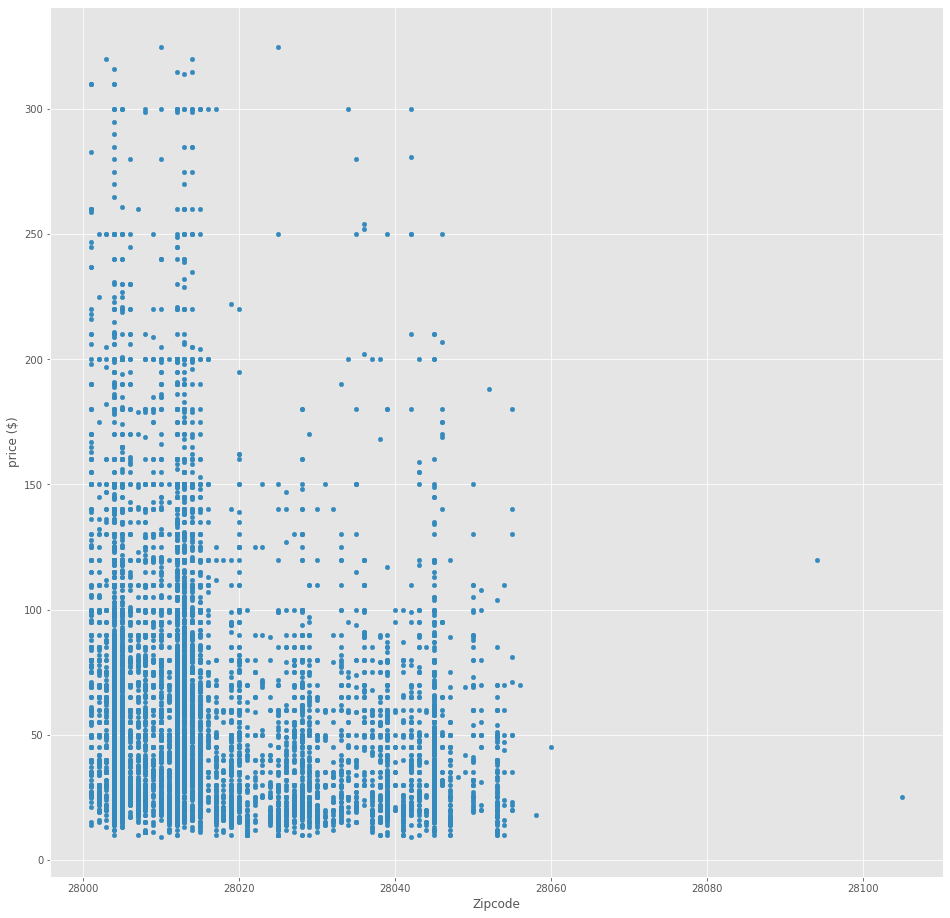

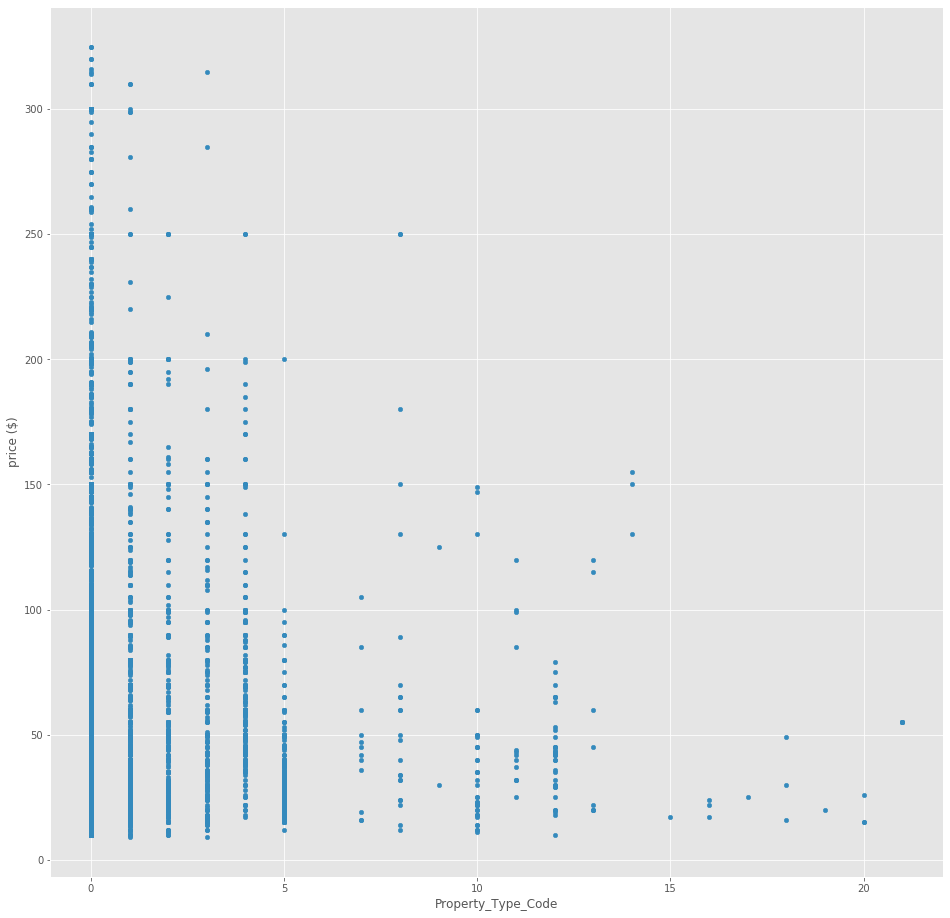

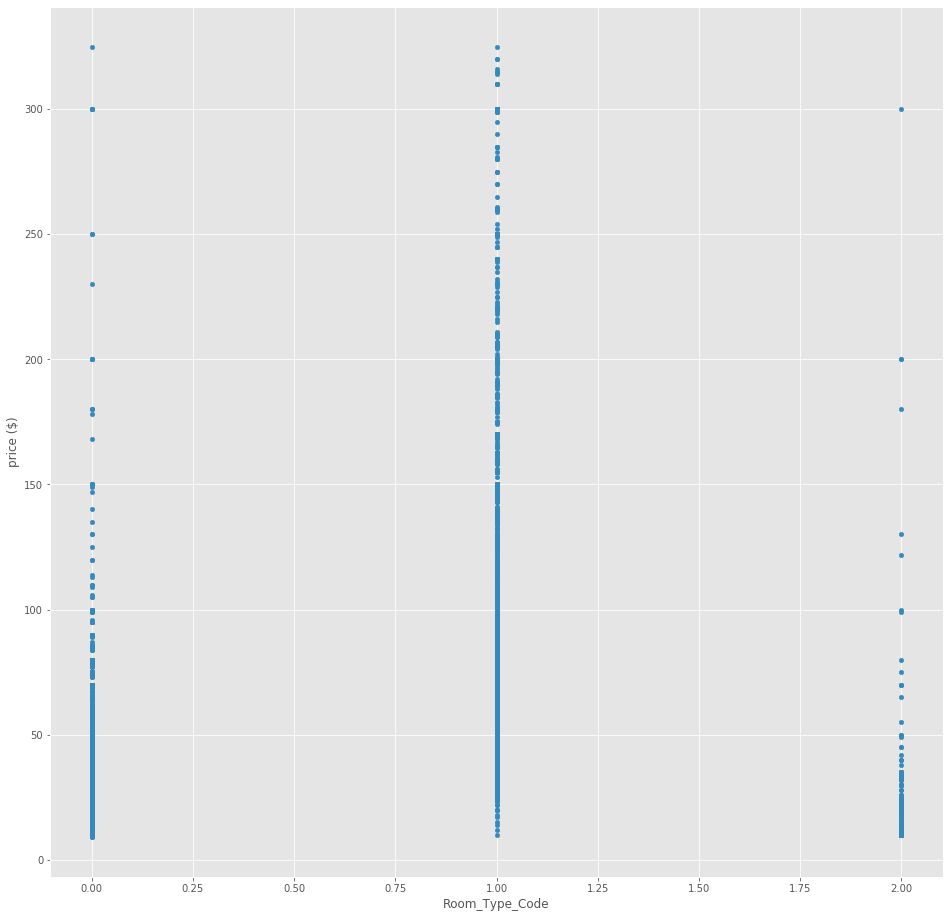

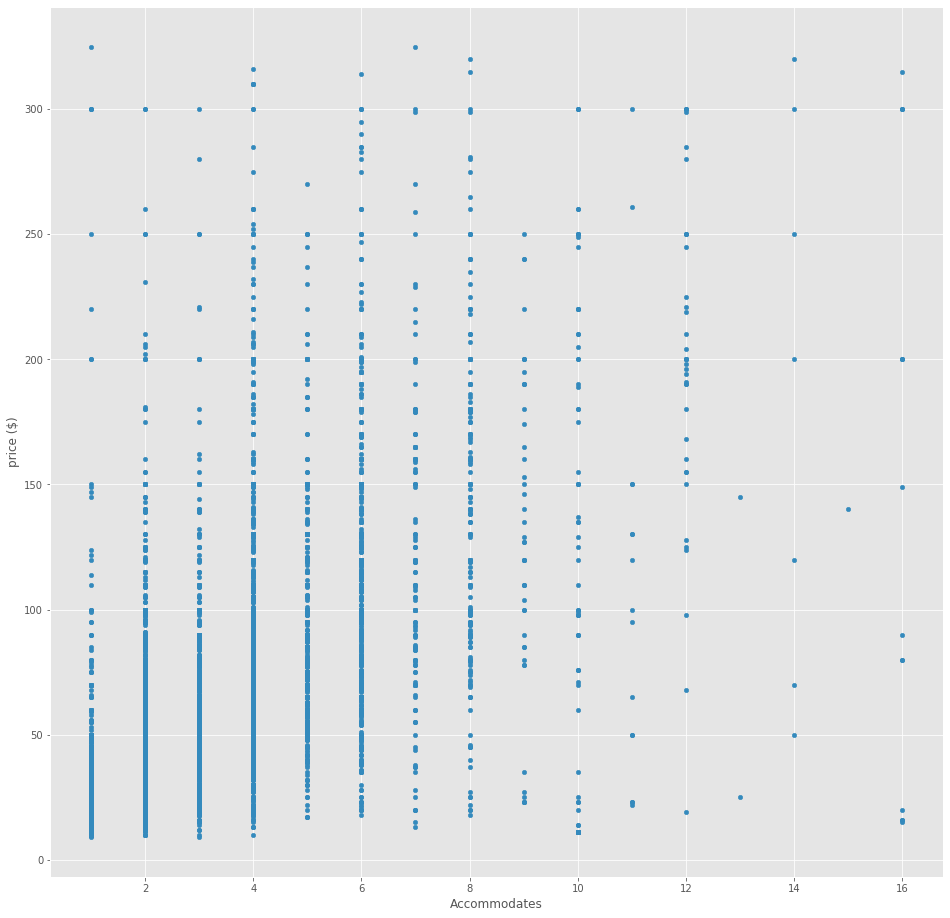

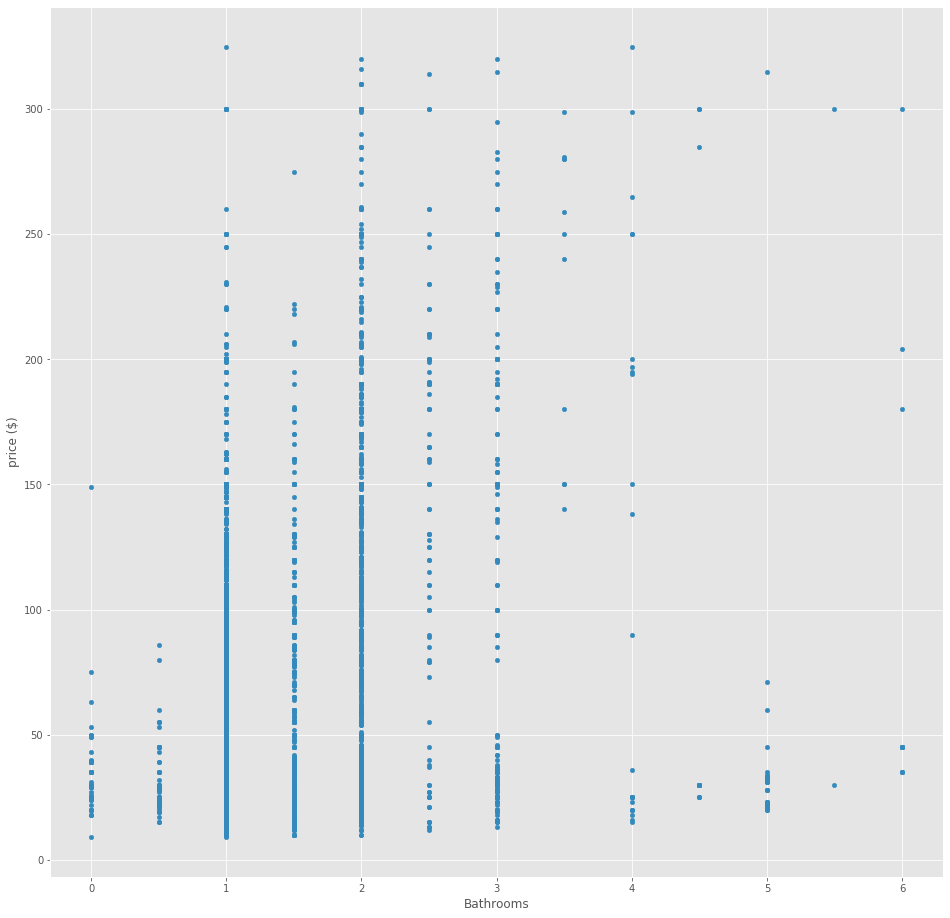

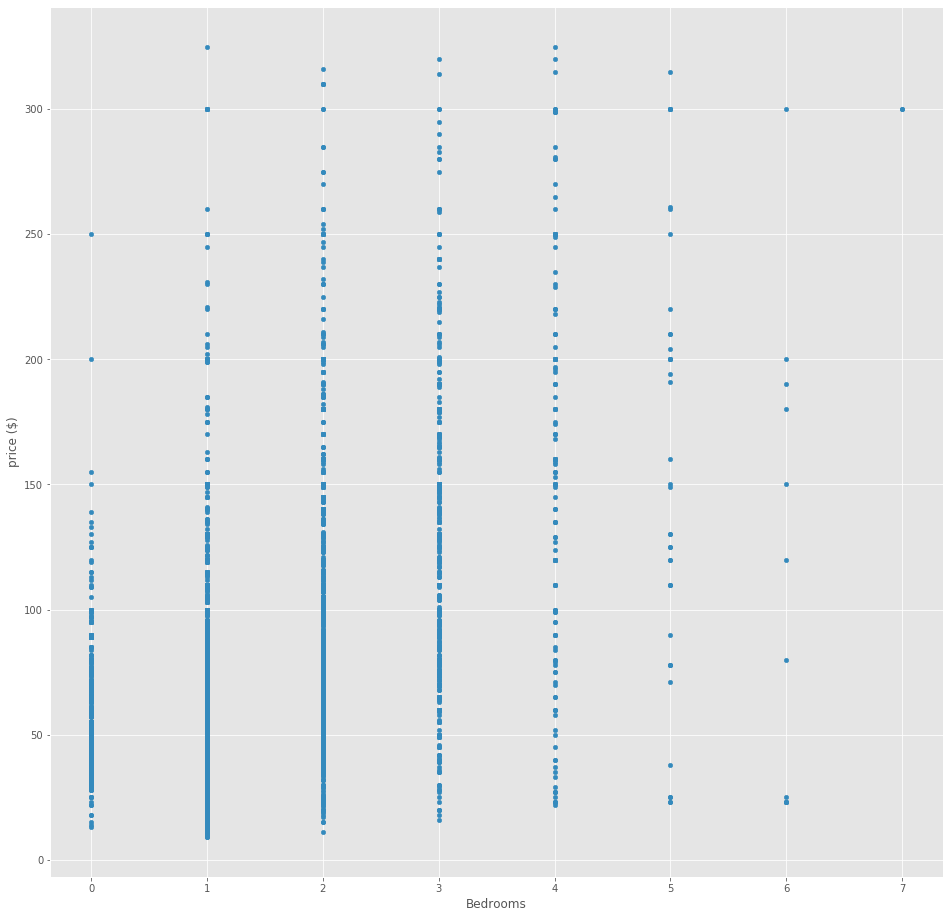

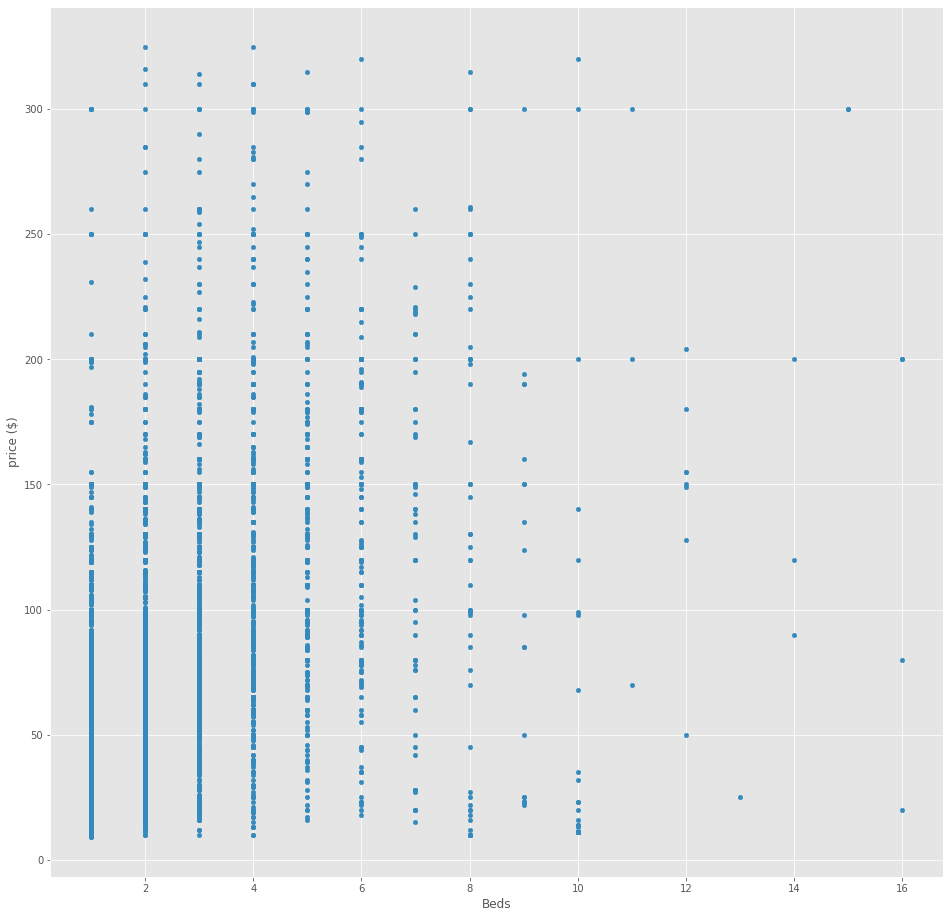

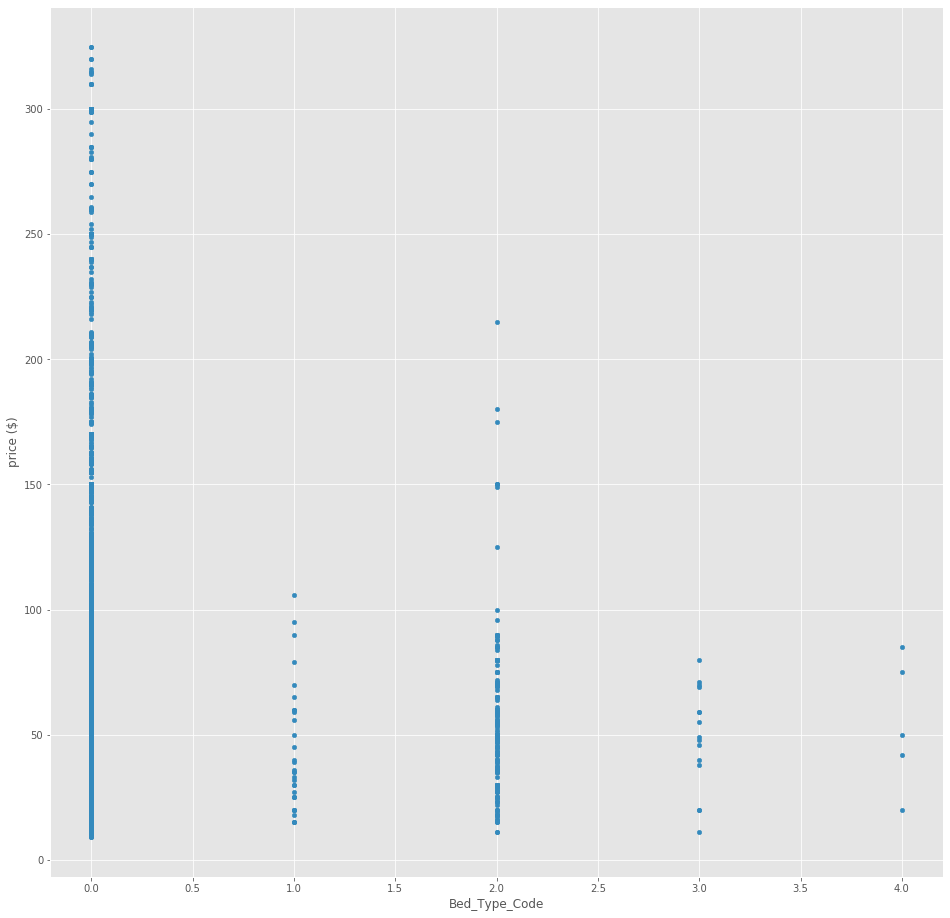

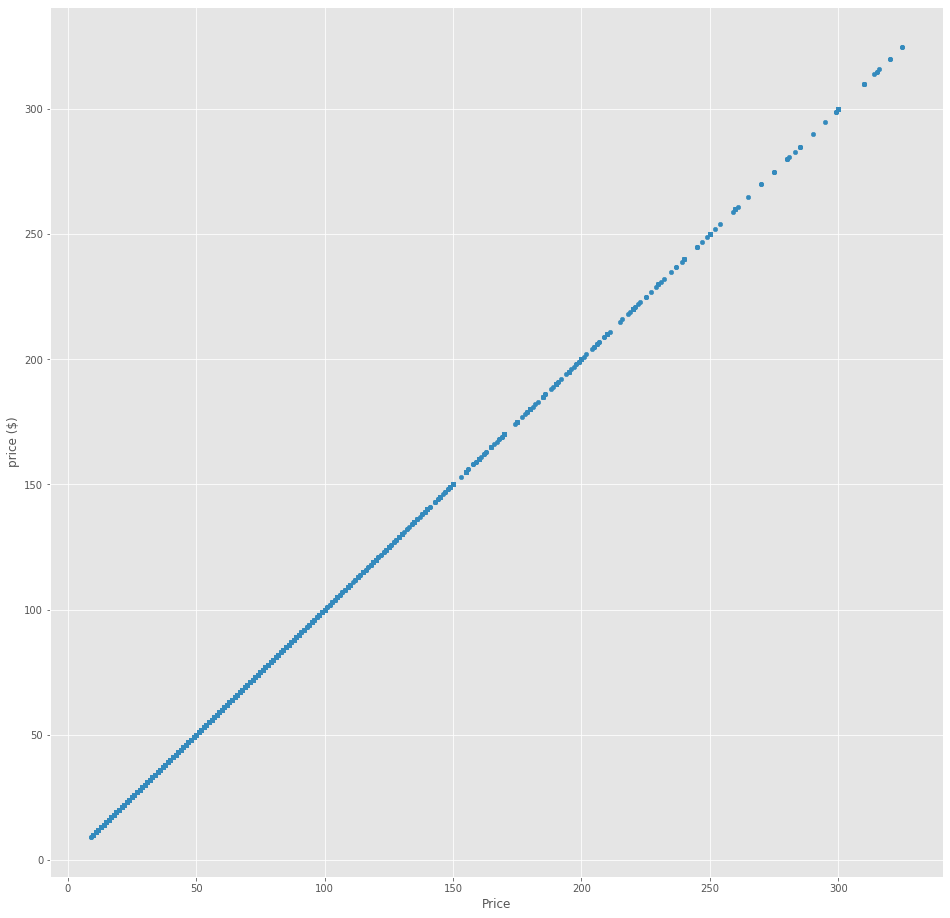

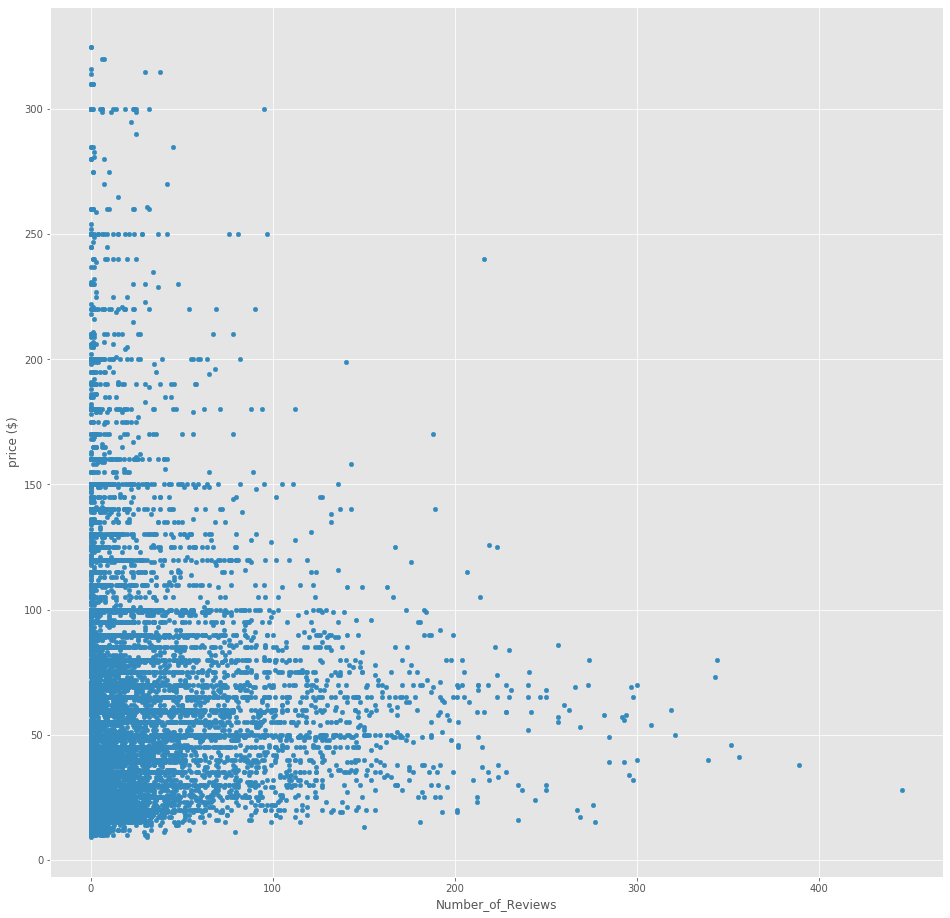

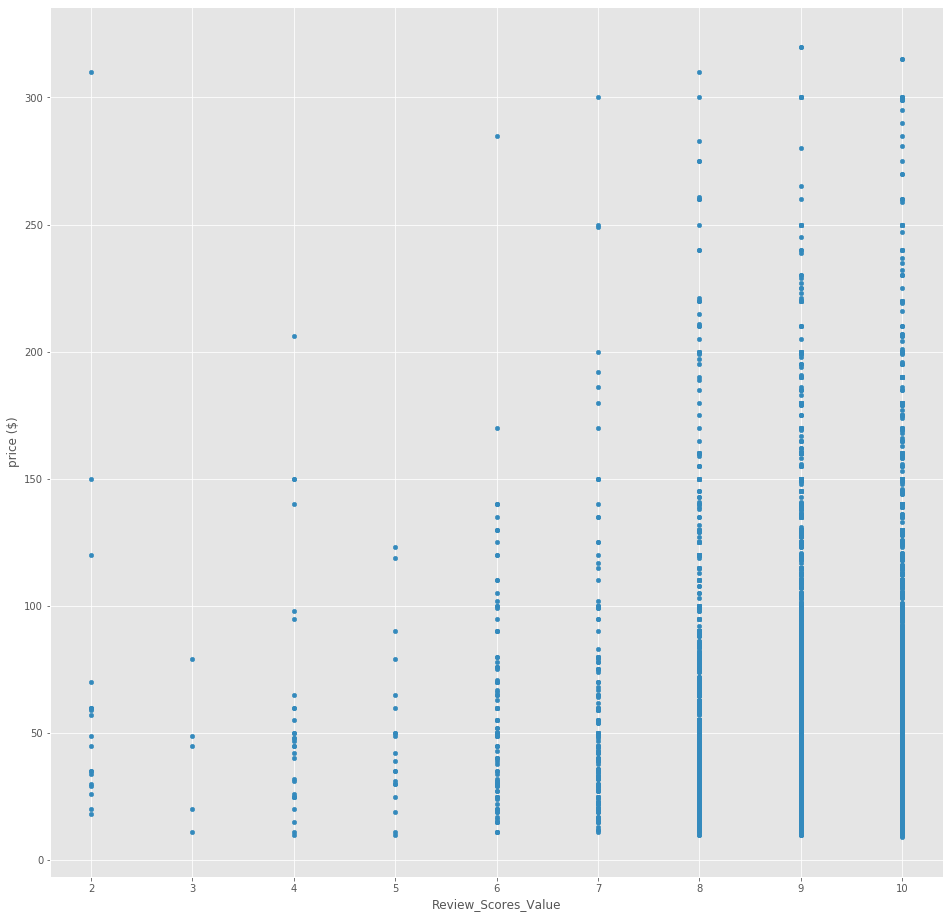

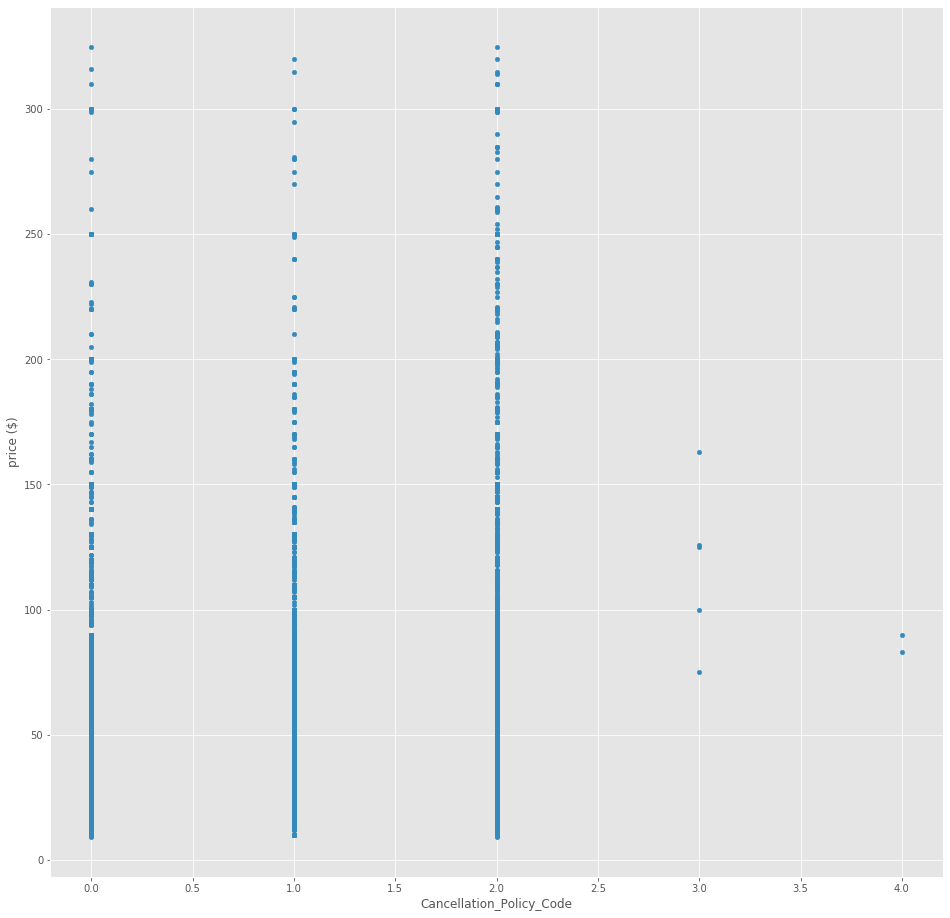

In [24]:
# Chequeo de nuevo los outlayers tras los cambios realizados:

df_filter = df

df_filter = delete_object_columns(df_filter)

for column in df_filter.columns:
    df_filter.plot(kind = 'scatter',x=f'{column}',y = 'Price')
    plt.xlabel(column)
    plt.ylabel('price ($)')
    plt.show()

Separo el dataset en dos para tener un dataset de train y otro de test.

In [25]:
#Calculo el número de filas que tengo en mi dataframe
nrows = df.shape[0]

### Creación del dataframe de train y el dataframe de test.

In [26]:
# Calculo el número de filas que voy a meter en el train y el número que voy a meter en test.
# En este caso utilizo un 75% del dataframe original para crear el dataset de train y el 25% para el dataset de test.

nrows_train = int(round(nrows*0.75,0))
nrows_test = int(nrows_train + 1)

In [27]:
# Creo un dataframe para train y otro para test.
df_train = df.iloc[:nrows_train, :]
df_test = df.iloc[nrows_test:, :]

In [28]:
print(df_train.shape)
print(df_test.shape)

(9449, 17)
(3149, 17)


### Limpieza del dataframe de train para crear el modelo predictivo.

In [29]:
df_train.isnull().sum(axis = 0)

Neighbourhood               3368
Zipcode                        0
Property_Type                  0
Property_Type_Code             0
Room_Type                      0
Room_Type_Code                 0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           8
Bed_Type                       0
Bed_Type_Code                  0
Price                          0
Number_of_Reviews              0
Review_Scores_Value         2202
Cancellation_Policy            0
Cancellation_Policy_Code       0
dtype: int64

In [30]:
# Los valores nulos que contiene el campo "review_scores_value" los voy a sustuir con la media:
reviews_score_mean = df_train["Review_Scores_Value"].mean()
df_train['Review_Scores_Value'] = df_train['Review_Scores_Value'].fillna(reviews_score_mean)

C:\Users\Usuario\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
df_train.isnull().sum(axis = 0)

Neighbourhood               3368
Zipcode                        0
Property_Type                  0
Property_Type_Code             0
Room_Type                      0
Room_Type_Code                 0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Beds                           8
Bed_Type                       0
Bed_Type_Code                  0
Price                          0
Number_of_Reviews              0
Review_Scores_Value            0
Cancellation_Policy            0
Cancellation_Policy_Code       0
dtype: int64

In [32]:
# Me quedo únicamente con los campos numéricos y los campos codificados y los convierto a int64.

df_train = delete_object_columns(df_train)
df_train = convert_to_numeric(df_train)

df_test = delete_object_columns(df_test)
df_test = convert_to_numeric(df_test)

In [33]:
# Elimino los valores nulos del dataframe de train:

# De esta forma puedo incluirlo en la matriz de correlación.

for column in df_train.columns:
    df_train= df_train[df_train[column].notna()]

#### Matriz de correlación creada a partir del dataframe de train.

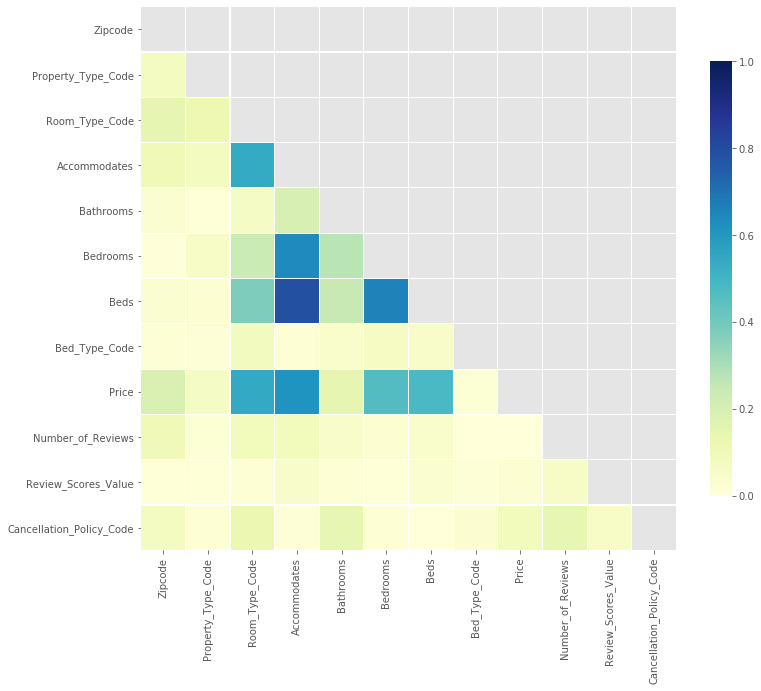

In [34]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Por lo que vemos en la matriz de correlación, el precio de una vivienda depende principalmente del número de personas, el número de baños, el número de habitaciones,el número de camas de la vivienda y el tipo de habitación.

En menor medida, parece que también depende del barrio.

Viendo la matriz de correlación, parece que que podemos eliminar las columnas de **Bed_Type**, **Property_type_code**, **Zipcode** para crear el modelo predictivo para calcular el precio.

In [35]:
df_train.corr() # matriz de correlación

,Zipcode,Property_Type_Code,Room_Type_Code,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type_Code,Price,Number_of_Reviews,Review_Scores_Value,Cancellation_Policy_Code
Zipcode,1.000000,0.076259,-0.149086,-0.103130,-0.032338,0.006211,-0.033025,-0.018402,-0.188742,-0.101872,0.010490,-0.075727
Property_Type_Code,0.076259,1.000000,-0.118366,-0.078099,0.007947,-0.056180,-0.025243,-0.013411,-0.069442,-0.022442,-0.007814,-0.017909
Room_Type_Code,-0.149086,-0.118366,1.000000,0.542731,-0.066447,0.236476,0.376111,0.085402,0.546241,0.090022,-0.018420,-0.129820
Accommodates,-0.103130,-0.078099,0.542731,1.000000,0.198646,0.643420,0.792153,-0.019524,0.614929,0.093641,-0.047150,0.014632
Bathrooms,-0.032338,0.007947,-0.066447,0.198646,1.000000,0.274705,0.247526,-0.041874,0.152257,-0.050162,-0.016906,0.145699
Bedrooms,0.006211,-0.056180,0.236476,0.643420,0.274705,1.000000,0.662408,-0.073037,0.467692,-0.024348,-0.007846,-0.017609
Beds,-0.033025,-0.025243,0.376111,0.792153,0.247526,0.662408,1.000000,-0.052951,0.481174,0.040052,-0.039006,0.003359
Bed_Type_Code,-0.018402,-0.013411,0.085402,-0.019524,-0.041874,-0.073037,-0.052951,1.000000,-0.019662,0.003020,0.012083,-0.029124
Price,-0.188742,-0.069442,0.546241,0.614929,0.152257,0.467692,0.481174,-0.019662,1.000000,-0.002824,0.024351,-0.092590
Number_of_Reviews,-0.101872,-0.022442,0.090022,0.093641,-0.050162,-0.024348,0.040052,0.003020,-0.002824,1.000000,0.061560,0.144920


### Elimino las columnas que parecen menos relevantes según la matriz de correlación

In [36]:
df_train = df_train.drop(columns=["Bed_Type_Code","Property_Type_Code","Zipcode","Number_of_Reviews","Review_Scores_Value"])

### Histograma del dataframe de entrenamiento

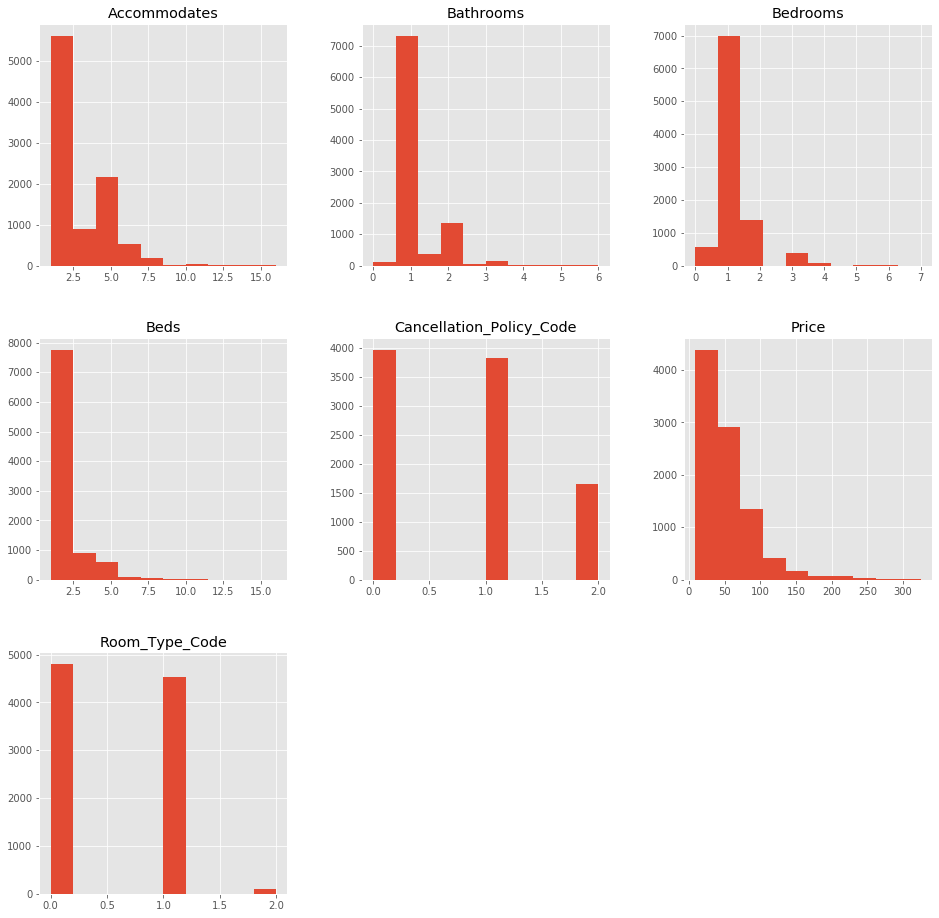

In [37]:
df_train.hist()
plt.show()

### Vamos a comentar las gráficas anteiores:

* Vemos que la mayoría de viviendas aceptan entre 1 y 5 personas.

* La mayoría de viviendas cuentan con un baño y unas pocas con 2 baños.

* Vemos que la mayoría de viviendas tiene entre 1 y 3 habitaciones. La mayoría cuenta solo con una.

* Respecto al número de camas, vemos que la mayoría de casas tiene solo 1 cama, pero también hay agunas viviendas que             cuentan hasta con 5 camas.

* Respecto a la política de cancelación, vemos que está muy repartido entre {'moderate':0,'flexible': 1,'strict':2}.

* Respecto al precio, vemos que la mayoría de viviendas oslizan entre 0 y 200€.

* Respecto a Property Type Code, vemos que la mayoría son {'Apartment': 0}.

* Respecto a los Room Type, vemos que la inmensa mayoría de viviendas que se ofertan son de tipo "Entire home/apt".
  {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}

In [38]:
# La función order columns recibe como parámetro el dataframe con el que estamos trabajando y ordena las columnas para 
# poder crear de una forma más sencilla el modelo. En este caso colocamos la columna "Price" en primer lugar.
def order_columns(dataframe):
    
    columns = []

    for column in dataframe.columns:
        if column == "Price":
            columns.insert(0, column)

        else:
            columns.append(column)    
            
    dataframe = dataframe[columns]
    
    return dataframe
    

In [39]:
# Implementamos la función "order_columns" tanto en el dataset de train como en el de test:
df_test = order_columns(df_test)
df_train = order_columns(df_train)

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


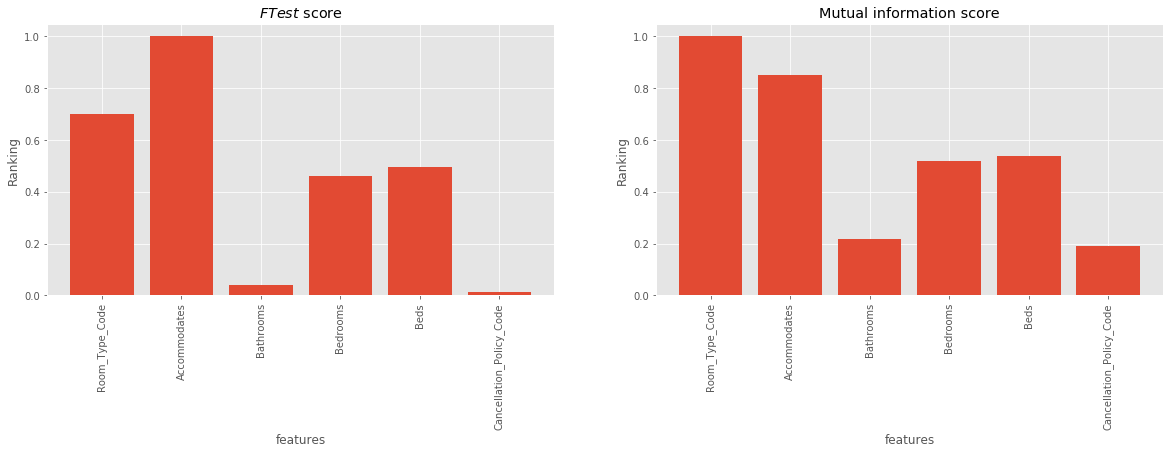

In [40]:
# convertimos el DataFrame al formato necesario para scikit-learn
# Pongo la columna "Price en primer lugar"

data = df_train.values 

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = df_train.columns[1:]


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

### La función check_dataframes

Sirve para asegurarnos que el dataframe de test no contiene nada que no sea reconocible por el modelo creado con el dataframe
de train

In [41]:
# La función check_dataframes, recibe como parámetros el dataframe de train y el de test.
# El objetivo de está función, es que no haya ningún dato en el dataframe de test que sea desconocido para el modelo predictivo
# que hemos creado con el dataframe de train.

def check_dataframes(df_train, df_test):
    
    df_train_columns = list(df_train.columns)
    
    df_test_columns = list(df_test.columns)
    
    for column in df_test_columns:
        if column not in df_train_columns:
            df_test = df_test.drop(columns = [f"{column}"])
    
    for column in df_train_columns:
        
        unique_values_train = [value for value in list(df_train[column].unique())]
        
        unique_values_test = [value for value in list(df_test[column].unique())]
        
        delete_values = [value for value in unique_values_test if value not in unique_values_train]
        
        for value in delete_values:
            df_test = df_test[df_test[column] != value] # Mantenemos en df_test solo los valores que conoce nuestro modelo.
        
    return df_train, df_test

In [42]:
df_train, df_test = check_dataframes(df_train,df_test)

In [43]:
# Vemos que apenas hemos perdido información tras la limpieza del dataset.

print(df_train.shape)
print(df_test.shape)

(9441, 7)
(3081, 7)


In [44]:
print(df_test.columns)
print(df_train.columns)

Index(['Price', 'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Cancellation_Policy_Code'],
      dtype='object')
Index(['Price', 'Room_Type_Code', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Cancellation_Policy_Code'],
      dtype='object')


In [46]:
from sklearn import preprocessing

data = df_train.values
y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto
feature_names = df_train.columns[1:]
# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

In [47]:

data_test = df_test.values
y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto
feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 